# EDA + Data Cleaning

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# read insurance data
data = pd.read_csv('insurance.csv')

# randomly create test and training dataset
np.random.seed(2)

train = data.sample(round(data.shape[0]*0.8)) # 80% i.e. 
test = data.drop(train.index)

print("Training data has ", train.shape[0], "observations.")
print("Test data has ", test.shape[0], "observations.")

Training data has  1070 observations.
Test data has  268 observations.


Goal: we want to predict the price of insurance based on a persons' characteristics. We also considered inference since it would be interesting to see which personal characteristic has the most influence on insurance prices

## Exploring the parameters

Quantitative parameters:

In [7]:
train.describe()

,age,bmi,children,charges
count,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.081308,30.831514,1.093458,13454.331986
std,14.021963,6.134072,1.206722,12451.054091
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.400000,0.000000,4719.577175
50%,39.000000,30.590000,1.000000,9289.083100
75%,51.000000,34.848750,2.000000,17071.645350
max,64.000000,53.130000,5.000000,63770.428010


There does not seem to be any missing data in the training dataset. The four quantitiative variables are ['age', 'bmi', 'children']. Our target variable is charges. We proceed with viewing the correlation between the quantitative parameters and target variable. 

In [8]:
train.corrwith(train['charges'])

age         0.304118
bmi         0.220865
children    0.068611
charges     1.000000
dtype: float64

All three variables seem to have positive correlation with charges. Correlation is relatively low (max 0.3). Below is a pairplot to reveal any non-linear relationships between the variables.

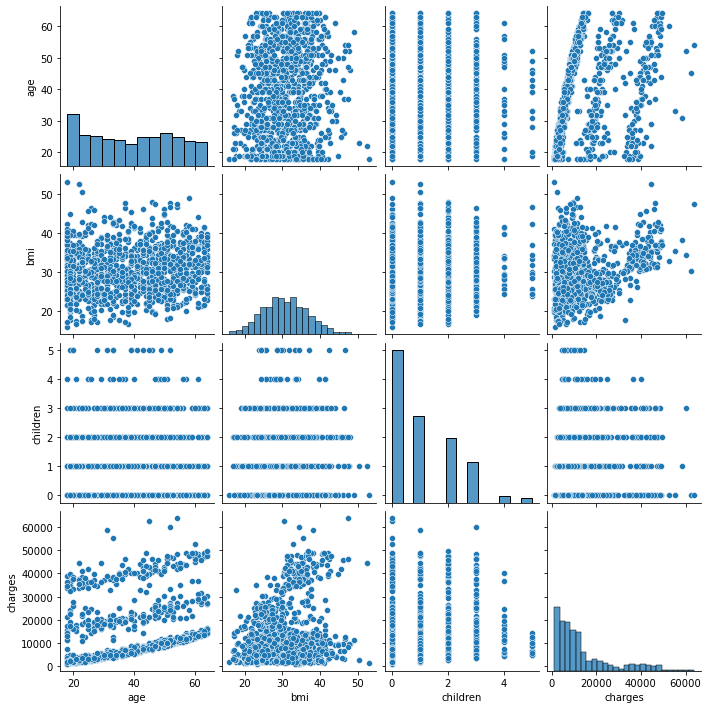

In [9]:
sns.pairplot(train)

Observations:
- the relationship between age and charges seems to be linear but split into three destinct lines (by charge 'tier')
- There seems to be two clusters in the bmi vs charges scatterplot (note the gap between charges in the two groups between bmi 30-40). Alternatively, this could be a sidways parabola. Either way, bmi may need to be transformed to capture non-linearity.
- It seems like the higher the number of children, the lower the spread of charges with a tendancy to be skewed towards lower charges but this may be because there are fewer observations with larger number of children.

Qualitative parameters:

In [10]:
train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Qualitative parameters include ['smoker','region']. The different classes are shown below:

In [11]:
# smoker
train['smoker'].value_counts()

no     850
yes    220
Name: smoker, dtype: int64

<AxesSubplot:xlabel='smoker', ylabel='charges'>

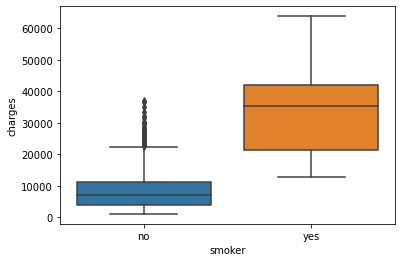

In [15]:
sns.boxplot(x = 'smoker', y = 'charges', data = train)

Approximately 21% of patients are smokers. The boxplot indicates there is a difference between charges of non smokers and smokers. Non-smokers have lower charges on average (median below 1k) and smaller spread. There seems to be a large number of outliers so further outlier detection is necessary for this group. Smokers have higher charges on average (median > 3.5k) and larger spread.

In [12]:
# region
train['region'].value_counts()

southeast    291
northwest    262
northeast    259
southwest    258
Name: region, dtype: int64

There seems to be a arelatively even distribution of individuals in each of the four regions.

<AxesSubplot:xlabel='region', ylabel='charges'>

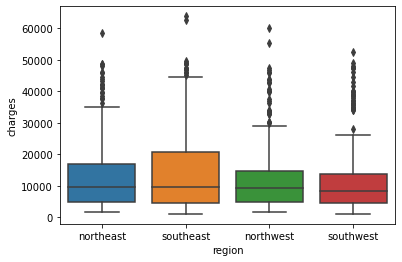

In [16]:
sns.boxplot(x = 'region', y = 'charges', data = train)

All regions seem to have the same median charge, but vary in terms of spread. The southeast region has the largest spread of data, followed by the northeast. On the otherhand, the north and southwest seem to have comparably low spreads. All regions have a substantial number of outliers so this will be further reviewed.

## Outliers and high leverage points

## Transformations

In [17]:
['age', 'bmi', 'children']

['age', 'bmi', 'children']

<AxesSubplot:xlabel='age', ylabel='charges'>

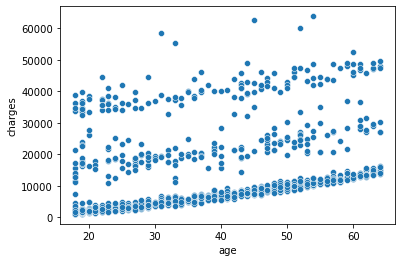

In [20]:
# age
sns.scatterplot(data = train, x = 'age', y = 'charges')

<AxesSubplot:xlabel='bmi', ylabel='charges'>

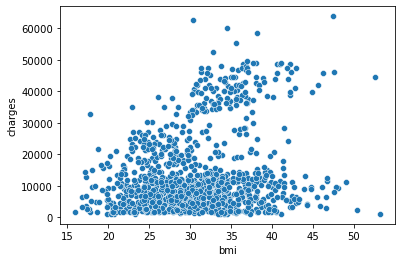

In [19]:
# bmi
sns.scatterplot(data = train, x = 'bmi', y = 'charges')

<AxesSubplot:xlabel='children', ylabel='charges'>

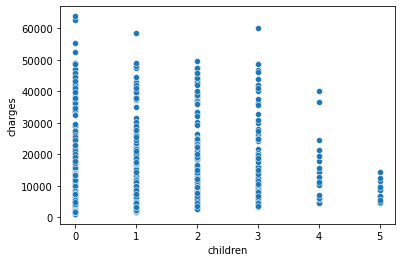

In [24]:
# children
sns.scatterplot(data = train, x = 'children', y = 'charges')

# Preliminary model

In [25]:
# function to fit lin reg model (input dataframe and formula)

def create_model(df, formula):
    # fit the model
    model = smf.ols(data = df, formula = formula).fit()
    display(model.summary())
    
    # calculate rse
    print('RSE: ', np.sqrt(model.mse_resid))
    
    # calculate rmse
    prediction = model.predict(df)
    print('RMSE: ', np.sqrt(((df.charges - prediction)**2).mean()))
    return model

In [27]:
# no transformations or interactions
create_model(df = train, formula = 'charges ~ age + bmi + children + smoker + region')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     487.2
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:30:46   Log-Likelihood:                -10838.
No. Observations:                1070   AIC:                         2.169e+04
Df Residuals:                    1062   BIC:                         2.173e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.217e+04   1094.404    -11.122      0.000   -1.43e+04      -1e+04
smoker[T.yes]        2.453e+04    462.163     53.082      0.000    2.36e+04    2.54e+04
region[T.northwest]  -424.2010    533.876     -0.795      0.427   -1471.772     623.370
region[T.southeast] -1285.0217    538.993     -2.384      0.017   -2342.634    -227.410
region[T.southwest]  -924.3507    537.191     -1.721      0.086   -1978.426     129.725
age                   257.0455     13.399     19.184      0.000     230.754     283.337
bmi                   346.4340     32.015     10.821      0.000     283.614     409.254
children              486.5285    154.747      3.144      0.002     182.884     790.173
==============================================================================
Omnibus:                      234.214   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              584.122
Skew:                           1.154   Prob(JB):                    1.44e-127
Kurtosis:                       5.788   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RSE:  6087.346321484451
RMSE:  6064.547191487781
